# Idea 4: Samples fitering - online

## Περιγραφή του αλγορίθμου
- Γίνεται εκπαίδευση με grokfast - EMA. Όταν **appl_sampl_filter** is False έχω μόνο αυτό, ενώ για True εφαρμόζω επιπλέον και την ιδέα 4 για πιο έξυπνη επιλογή δειγμάτων.
- Ο Dataloader έχει έναν custom sampler (WeightedRandomSampler) ο οποίος κάθε φορά διαλέγει ένα δείγμα με βάση κάποιο βάρος/πιθανότητα.
- Στην αρχή τα βάρη είναι όλα ίδια (ομοιόμορφη κατανομή) οπότε ο Dataloader λειτουργεί όπως συνήθως διαλέγοντας τυχαία ένα sample.
- Σε κάθε επανάληψη φτιάχνεται ένα ranking των δειγμάτων (με βάση του πόσο high frequency περιέχει το καθένα) το οποίο χρησιμοποιείται για να αποφασιστεί τι βάρος/πιθανότητα θα δοθεί σε κάθε δείγμα να επιλεγεί για εκπαίδευση. Το διάνυσμα βαρών/πιθανοτήτων ανανεώνεται κάθε **sampling_distr_upd_freq** επαναλήψεις.
- Στην κατασκευή του διανύσματος βαρών από την συνολική πιθανότητα 1 δίνουμε στα **top_k** δείγματα συνολικά **top_k_sampling_prob** (και στα υπόλοιπα length(dataset) - **top_k** δείγματα δίνουμε συνολικά το υπόλοιπο 1 - **top_k_sampling_prob**).
- Με **high_freq_better** is True ακολουθούμε την αρχική μας υπόθεση ότι τα δείγματα με high frequency είναι αυτά που θα πρέπει να ταΐσουμε το δίκτυο περισσότερο για να μάθει γρηγορότερα, για False γίνεται το αντίθετο.

## Οδηγίες χρήσης για τρέξιμο
Πήγαινε στον τίτλο **Execute training (by running main funciton)**. Πήγαινε στο parser.parse_args και όρισε τις τιμές που θες να δοκιμάσεις για grid search. Οι υπερπαράμετροι που σχετίζονται με την ιδέα 4 online είναι:

- **top_k**
- **top_k_sampling_prob**
- **high_freq_better**
- **sampling_distr_upd_freq**: Μάλλον είναι οκ στο 1 γιατί ακόμα και έτσι η εκπαίδευση δεν είναι αργή οπότε δεν έχω λόγο να το αυξήσω.

Αν κάποιος θέλει να τρέξει κάποιες τιμές για το grid search, έχω βάλει στον φάκελο και ένα αρχείο για να σημειώνουμε τις τιμές των υπερπαραμέτρων που δοκίμασε ο καθένας για να μην τρέχουμε όλοι τα ίδια. Βάλτε GPU P100 (νομίζω είναι ελαφρώς καλύτερη), εμένα για τα 100.000 βήματα που έχω βάλει να είναι το default ένα τρέξιμο που κάνω μόνο με grokfast (δηλαδή **appl_sampl_filter** is False) παίρνει περίπου **7 λεπτά** οπότε καλά είμαστε από χρόνο.



In [1]:
import kagglehub

# Maybe this is needed if you want to import private datasets 
# kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# hojjatk_mnist_dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

# The dataset was uploaded from me but I made it public so you too can probably load it with this line
_ = kagglehub.dataset_download("konstantinosbarkas/mnist-dataset-processed-from-local")

print("Data source import complete.")


Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/mnist-dataset-processed-from-local/MNIST_data_processed_from_local/train.pt
/kaggle/input/mnist-dataset-processed-from-local/MNIST_data_processed_from_local/test.pt


In [4]:
# !pip install -r /kaggle/input/enter-data-dn-req/requirements.txt


In [5]:
# Install the Grokfast library
!wget https://raw.githubusercontent.com/ironjr/grokfast/main/grokfast.py

sys.path.append("/kaggle/working")


--2025-01-30 02:34:28--  https://raw.githubusercontent.com/ironjr/grokfast/main/grokfast.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1703 (1.7K) [text/plain]
Saving to: ‘grokfast.py’

grokfast.py         100%[===================>]   1.66K  --.-KB/s    in 0s      

2025-01-30 02:34:28 (28.3 MB/s) - ‘grokfast.py’ saved [1703/1703]



In [6]:
# import argparse
# import gzip
import math
import random
# import struct
import time
from argparse import ArgumentParser
# from collections import Counter, defaultdict, deque
from itertools import islice
# from pathlib import Path
# from typing import Dict, List, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
# import torchvision.transforms as transforms
from functorch import grad, vmap
from sklearn.model_selection import train_test_split
from torch.autograd import grad

# from torch.nn.utils.stateless import functional_call, # This is deprecated, use the next one instead
from torch.func import functional_call
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, Dataset
from tqdm.auto import tqdm

from grokfast import gradfilter_ema


In [7]:
results_dir = "/kaggle/working/results/mnist_online"
os.makedirs(results_dir, exist_ok=True)
dataset_path = "/kaggle/input/mnist-dataset-processed-from-local/MNIST_data_processed_from_local"


In [8]:
optimizer_dict = {"AdamW": torch.optim.AdamW, "Adam": torch.optim.Adam, "SGD": torch.optim.SGD}

activation_dict = {"ReLU": nn.ReLU, "Tanh": nn.Tanh, "Sigmoid": nn.Sigmoid, "GELU": nn.GELU}

loss_function_dict = {"MSE": nn.MSELoss, "CrossEntropy": nn.CrossEntropyLoss}


In [9]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


In [10]:
def custom_collate_fn_2(batch):
    """Custom collate function to handle extra fields in the dataset."""
    images, labels, _, _ = zip(*batch)  # Ignore the indices and extra_fields for loss computation
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return images, labels


def compute_accuracy(model, dataset, device, N=None):
    """Utility to compute accuracy on a given dataset."""
    correct = 0
    total = 0

    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn_2)

    for x, y in loader:  # Unpack index and extra_fields as well
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            predictions = outputs.argmax(dim=1)
        correct += (predictions == y).sum().item()
        total += y.size(0)
        if N is not None and total >= N:
            break
    return correct / total


def compute_loss(model, dataset, loss_function_name, device, N=None):
    """Utility to compute the average loss on a given dataset."""
    loss_fn = loss_function_dict[loss_function_name]()

    loader = DataLoader(dataset, batch_size=256, shuffle=False, collate_fn=custom_collate_fn_2)
    total_loss = 0.0
    count = 0
    one_hots = torch.eye(10, device=device)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            outputs = model(x)
            if loss_function_name == "CrossEntropy":
                loss = loss_fn(outputs, y)
            elif loss_function_name == "MSE":
                loss = loss_fn(outputs, one_hots[y])
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        count += batch_size
        if N is not None and count >= N:
            break
    return total_loss / count


In [11]:
# Added extra fields to keep ema_gra and history
# In this implementation I use variance metric --> I don't also store deviation metric for memory efficiency
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, data, targets, transform=None):
        """
        Custom dataset to simulate MyMNIST behavior with extra fields.
        Args:
            data: Tensor of shape [N, 28, 28].
            targets: Tensor of shape [N].
            transform: Transformations to apply to the images.
        """
        self.data = data.to(torch.float32)
        self.targets = targets
        self.transform = transform

        # Initialize extra fields
        self.extra_fields = [
            {
                "ema_grad": 0.0,  # EMA of gradient
                "num_updates": 0,
                # "deviation_metric": 0.0, # Deviation metric
                "variance_metric": 0.0,  # Variance metric
            }
            for _ in range(len(self.data))
        ]

    def __getitem__(self, index):
        """
        Returns a single data sample and its associated extra fields.
        """
        img, target = self.data[index], self.targets[index]
        if self.transform:
            img = self.transform(img)
        extra_field = self.extra_fields[index]
        return img, target, index, extra_field

    def update_fields(self, indices, grad_stats, ema_alpha=0.9):
        """
        Update the extra fields for specified dataset indices.
        """

        for idx, grad in zip(indices, grad_stats):
            # Update EMA
            sample_field = self.extra_fields[idx]

            current_ema = sample_field["ema_grad"]
            updated_ema = ema_alpha * current_ema + (1 - ema_alpha) * grad
            sample_field["ema_grad"] = updated_ema

            deviation = abs(grad - updated_ema)

            num_updates = sample_field["num_updates"] + 1  # Increment the update count
            # current_avg_deviation = sample_field["deviation_metric"]
            current_avg_deviation = sample_field["variance_metric"] ** 0.5
            new_avg_deviation = ((current_avg_deviation * (num_updates - 1)) + deviation) / num_updates

            # Update the deviation metric and number of updates
            sample_field["deviation_metric"] = new_avg_deviation
            sample_field["num_updates"] = num_updates

            # sample_field["deviation_metric"] += deviation

            # Optionally update variance-like metric
            # Variance estimate (for higher sensitivity to fast changes)
            sample_field["variance_metric"] = new_avg_deviation**2


In [12]:
def custom_collate_fn(batch):
    images, labels, indices, extra_fields = zip(*batch)
    images = torch.stack(images)  # Stack images into a single tensor
    labels = torch.tensor(labels)  # Convert labels to a tensor
    return images, labels, indices, extra_fields


In [13]:
# Needed for per sample gradient computations
def select_random_subset(tensor, percentage, seed=42):
    """
    Flatten the parameter dimensions for each batch sample, select a percentage of elements,
    and return a tensor with shape [batch_size, selected_elements].

    Args:
        tensor (torch.Tensor): The gradient tensor of shape [batch_size, *parameter_dims].
        percentage (float): The percentage of elements to select.
        seed (int): Random seed for reproducibility.

    Returns:
        torch.Tensor: A tensor of shape [batch_size, selected_elements].
    """
    batch_size, *param_dims = tensor.shape  # Extract batch and parameter dimensions
    total_params = torch.prod(torch.tensor(param_dims))  # Total parameters per sample
    subset_size = int(total_params * percentage)  # 20% of parameters

    # Set seed for reproducibility
    random.seed(seed)
    indices = random.sample(range(total_params), subset_size)  # Random indices for selection

    # Flatten parameter dimensions and select elements for each batch
    flat_tensor = tensor.view(batch_size, -1)  # Flatten parameter dimensions for each sample
    selected_subset = flat_tensor[:, indices]  # Select the same random indices across the batch

    return selected_subset


In [14]:
# Needed for online sample filtering
def rank_to_sampling_weights(my_dataset, top_k, top_k_sampling_prob, high_freq_better):
    """
    Rank samples by variance_metric and assign sampling weights.

    Parameters:
    - my_dataset: MyMNIST object.
    - top_k: Fraction of top samples to assign higher sampling probability.
    - top_k_sampling_prob: Probability assigned to the top_k fraction of samples.

    Returns:
    - new_weights: List of sampling weights for each sample.
    """
    # Calculate the number of top_k samples
    num_samples = len(my_dataset)
    top_k_count = int(top_k * num_samples)

    # Sort indices by variance_metric in descending order
    sorted_indices = sorted(
        range(num_samples),
        key=lambda idx: my_dataset.extra_fields[idx]["variance_metric"],
        reverse=high_freq_better,
    )

    # Initialize new_weights with zeros
    new_weights = [0.0] * num_samples

    # Assign weights to the top_k samples
    for idx in sorted_indices[:top_k_count]:
        new_weights[idx] = top_k_sampling_prob / top_k_count

    # Assign weights to the rest of the samples
    for idx in sorted_indices[top_k_count:]:
        new_weights[idx] = (1 - top_k_sampling_prob) / (num_samples - top_k_count)

    return new_weights


## def main

In [15]:
def main(args):
    log_freq = math.ceil(args.optimization_steps / 150)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32
    one_hots = torch.eye(10, 10).to(device)

    torch.set_default_dtype(dtype)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    random.seed(args.seed)
    np.random.seed(args.seed)

    #                                 Load dataset
    #   -------------------------------------------------------------------------------   #
    train_data = torch.load(f"{dataset_path}/train.pt", weights_only=True)
    test_data = torch.load(f"{dataset_path}/test.pt", weights_only=True)

    transform = None

    train_images, train_labels = train_data
    test_images, test_labels = test_data

    # Create MyMNIST datasets
    train_dataset = MyMNIST(train_images, train_labels, transform=transform)
    test_dataset = MyMNIST(test_images, test_labels, transform=transform)
    test = test_dataset  # For compatibility with our older code

    # Create indices & stratify
    train_indices = list(range(len(train_dataset)))
    train_labels = [train_dataset.targets[i].item() for i in train_indices]

    # Use train_test_split with stratification to randomly select a specified number of samples (args.train_points)
    stratified_indices, _ = train_test_split(
        train_indices,
        train_size=args.train_points,
        stratify=train_labels,
        random_state=args.seed,
    )

    train_subset = Subset(train_dataset, stratified_indices)

    # Create initial weights for uniform sampling
    weights = [1.0] * len(train_subset)
    sampler = WeightedRandomSampler(weights, len(weights))

    train_loader = DataLoader(train_subset, batch_size=args.batch_size, sampler=sampler, collate_fn=custom_collate_fn)

    activation_fn = activation_dict[args.activation]

    #                                   Create model
    #   -------------------------------------------------------------------------------   #

    layers = [nn.Flatten()]
    for i in range(args.depth):
        if i == 0:
            layers.append(nn.Linear(784, args.width))
            layers.append(activation_fn())
        elif i == args.depth - 1:
            layers.append(nn.Linear(args.width, 10))
        else:
            layers.append(nn.Linear(args.width, args.width))
            layers.append(activation_fn())
    mlp = nn.Sequential(*layers).to(device)
    with torch.no_grad():
        for p in mlp.parameters():
            p.data = args.initialization_scale * p.data
    nparams = sum([p.numel() for p in mlp.parameters() if p.requires_grad])
    print(f"Number of parameters: {nparams}")

    # create optimizer
    assert args.optimizer in optimizer_dict, f"Unsupported optimizer choice: {args.optimizer}"
    optimizer = optimizer_dict[args.optimizer](mlp.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # define loss function
    assert args.loss_function in loss_function_dict
    loss_fn = loss_function_dict[args.loss_function]()

    # Needed for per sample gradient computations
    if args.appl_sampl_filter:
        # Define a function for forward + loss computation
        def compute_loss_vmap(params, buffers, model, x, y):
            # Use functional_call to pass parameters and buffers explicitly
            logits = functional_call(model, {**params, **buffers}, x.unsqueeze(0))  # Single input
            loss = loss_fn(logits, y.unsqueeze(0))  # Single output
            return loss.mean()
    
        # Prepare model parameters and buffers
        params_and_buffers = {**dict(mlp.named_parameters()), **dict(mlp.named_buffers())}
    
        params = {k: v for k, v in params_and_buffers.items() if v.requires_grad}
        buffers = {k: v for k, v in params_and_buffers.items() if not v.requires_grad}
    
        # Create the gradient function
        gradient_fn = grad(compute_loss_vmap)
    
        # Initialize EMA and metric history for each sample
        gradient_ema = [0.0 for _ in range(len(train_subset))]
        # gradient_metric_history = [[] for _ in range(len(train_subset))] # Probably unused

    #                           Start Training below
    #   -------------------------------------------------------------------------------   #
    log_steps, train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], [], []
    one_hots = torch.eye(10, 10).to(device)

    grads = None

    with tqdm(total=args.optimization_steps, dynamic_ncols=True) as pbar:

        reached_early_stop = False  # Flag to indicate early stopping
        steps_to_reach_val_acc = None  # Variable to store steps for 0.95 validation accuracy

        stable_threshold = 100  # Number of steps the validation accuracy must remain > 0.9
        stable_steps = 0  # Counter for steps validation accuracy remains above 0.9

        for step in range(args.optimization_steps):
            if reached_early_stop: break
            # Update the sampling distribution (according to the latest ranking of the samples)
            if args.appl_sampl_filter:
                if step % args.sampling_distr_upd_freq == 0 and step != 0:
                    # Update the weights of the sampling based on the latest gradient metrics
                    weights = rank_to_sampling_weights(train_subset, args.top_k, args.top_k_sampling_prob, args.high_freq_better)
                    sampler = WeightedRandomSampler(weights, num_samples=len(weights))
                    train_loader = DataLoader(
                        train_subset,
                        batch_size=args.batch_size,
                        sampler=sampler,
                        collate_fn=custom_collate_fn_2,
                    )

            for batch in islice(cycle(train_loader), 1):
                x, labels, indices, _ = batch
                do_log = (step < 30) or (step < 150 and step % 10 == 0) or step % log_freq == 0
                if do_log:
                    train_losses.append(compute_loss(mlp, train_subset, args.loss_function, device, N=len(train_subset)))
                    train_accuracies.append(compute_accuracy(mlp, train_subset, device, N=len(train_subset)))
                    test_losses.append(compute_loss(mlp, test, args.loss_function, device, N=len(test)))
                    test_accuracies.append(compute_accuracy(mlp, test, device, N=len(test)))
                    log_steps.append(step)
                    pbar.set_description(
                        "Loss: {0:1.1e}|{1:1.1e}. Acc: {2:2.1f}%|{3:2.1f}%".format(
                            train_losses[-1],
                            test_losses[-1],
                            train_accuracies[-1] * 100,
                            test_accuracies[-1] * 100,
                        )
                    )

                optimizer.zero_grad()

                x, labels = x.to(device), labels.to(device)
                y = mlp(x.to(device))
                if args.loss_function == "CrossEntropy":
                    # Use integer labels for CrossEntropyLoss
                    loss = loss_fn(y, labels)
                elif args.loss_function == "MSE":
                    loss = loss_fn(y, one_hots[labels])

                loss.backward(create_graph=True)

                if args.appl_sampl_filter:  # Unnecessary if we are not applying sample filtering
                    # -----------------------------------------------------------------
                    #   Gradient Stats: Capture grads for each sample
                    # -----------------------------------------------------------------
                    # Identify the last two Linear layers dynamically
                    batch_gradients = []

                    # Use vmap for batch gradient computation
                    per_sample_grads = vmap(gradient_fn, in_dims=(None, None, None, 0, 0))(params, buffers, mlp, x, labels)

                    last_layer_grad = per_sample_grads["3.weight"]  # Replace with your actual parameter name
                    second_last_layer_grad = per_sample_grads["5.weight"]

                    percentage_s_l = 0.2  # Adjust percentage as needed
                    percentage_l = 0.5
                    selected_last = select_random_subset(last_layer_grad, percentage_l, seed=42)
                    selected_second_last = select_random_subset(second_last_layer_grad, percentage_s_l, seed=42)

                    selected_last_avg = selected_last.mean(dim=-1)
                    selected_second_last_avg = selected_second_last.mean(dim=-1)
                    total_avg = (selected_last_avg + selected_second_last_avg) / 2

                    train_subset.dataset.update_fields(indices, total_avg, args.ema_alpha_sampl_rank)

                    # -----------------------------------------------------------------
                    # -----------------------------------------------------------------

                # Grokfast (EMA)
                grads = gradfilter_ema(mlp, grads=grads, alpha=args.alpha, lamb=args.lamb)

                optimizer.step()

                # Check for early stopping conditions
                test_acc = test_accuracies[-1] if len(test_accuracies) > 0 else 0

                # Normally it is for 0.95 - 0.9
                if test_acc >= 0.9 and steps_to_reach_val_acc is None:
                    steps_to_reach_val_acc = step  # Record the first step reaching 0.9 validation accuracy

                if test_acc > 0.85:
                    stable_steps += 1
                else:
                    stable_steps = 0  # Reset counter if accuracy drops below 0.85

                if stable_steps >= stable_threshold and test_acc >= 0.9:
                    reached_early_stop = True
                    print(f"Validation accuracy of 0.9 reached and remained > 0.85 for {stable_threshold} step at step {step}")

                pbar.update(1)
                

    # Save results
    specific_result_dir = f"mnist_{args.label}.pt"
    results_filename = os.path.join(results_dir, specific_result_dir)
    torch.save(
        {
            "its": log_steps,
            "train_acc": train_accuracies,
            "train_loss": train_losses,
            "val_acc": test_accuracies,
            "val_loss": test_losses,
            "steps_to_reach": steps_to_reach_val_acc,
            "model_state_dict": mlp.state_dict(),  # Save the model's state dictionary, maybe unnecessary
        },
        results_filename,
    )

    print(f"\nSteps needed to reach 0.9 validation accuracy: {steps_to_reach_val_acc}")


In [16]:
# Remove the extra arguments passed by the Jupyter Notebook kernel
sys.argv = [""]


## Execute training (by running main function)

In [17]:
# Custom parameters (not the same with Grokfast's implementation)
# if __name__ == "__main__":
#     # Same as used in paper of Grokfast
#     parser = ArgumentParser(description="Train a model on MNIST with custom sampling")
    
#     parser.add_argument("--label", type=str, default="")
#     parser.add_argument("--seed", type=int, default=42)
    
#     parser.add_argument("--train_points", type=int, default=1000)
#     parser.add_argument("--optimization_steps", type=int, default=100000)
#     parser.add_argument("--batch_size", type=int, default=200)
#     parser.add_argument("--loss_function", type=str, default="CrossEntropy")  # changed
#     parser.add_argument("--optimizer", type=str, default="AdamW")
#     parser.add_argument("--weight_decay", type=float, default=0.01)
#     parser.add_argument("--lr", type=float, default=1e-3)
#     parser.add_argument("--initialization_scale", type=float, default=8.0)
#     parser.add_argument("--download_directory", type=str, default=".")
#     parser.add_argument("--depth", type=int, default=5)  # changed
#     parser.add_argument("--width", type=int, default=512)  # changed
#     parser.add_argument("--activation", type=str, default="ReLU")

#     # Grokfast
#     parser.add_argument("--alpha", type=float, default=0.99)
#     parser.add_argument("--lamb", type=float, default=5.0)

#     # Samples ranking
#     parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

#     # Boolean arguements need this due to bad behavior of parser.parse_args
#     def boolean_string(s):
#         if s not in {"False", "True"}:
#             raise ValueError("Not a valid boolean string")
#         return s == "True"

#     # These are the hyperparameters related to our online sampling filtering algorithm
#     parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
#     parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
#     parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
#     parser.add_argument("--top_k_sampling_prob", type=float, default=0.9)  # Probability of selecting a sample from the top-k
#     parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training

#     # -----------------------------------------------------------------
#     # Try different hyperparameter values for your grid search here
#     # -----------------------------------------------------------------
#     args = parser.parse_args(
#         [
#             "--appl_sampl_filter", "False", # booleans as non strings in order to work
#             "--sampling_distr_upd_freq", "1", # the rest as strings for some reason
#             "--top_k", "0.1",
#             "--top_k_sampling_prob", "0.9",
#             "--high_freq_better", "True",
#         ]
#     )
#     # -----------------------------------------------------------------
#     # -----------------------------------------------------------------

#     # Create arg.label for the filename of the saved results
#     if not args.appl_sampl_filter:
#         args.label = "only_grokfast"
#     else:
#         args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

#     # Training with time recording

#     # Start the timer
#     start_time = time.time()

#     # Call your training function
#     main(args)

#     # End the timer
#     end_time = time.time()

#     # Calculate elapsed time
#     elapsed_time = end_time - start_time

#     # Convert to minutes and seconds (optional)
#     minutes, seconds = divmod(elapsed_time, 60)

#     print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")


In [18]:
if __name__ == "__main__":
    # Same as used in paper of Grokfast
    parser = ArgumentParser(description="Train a model on MNIST with custom sampling")
    
    parser.add_argument("--label", type=str, default="")
    parser.add_argument("--seed", type=int, default=0)
    
    parser.add_argument("--train_points", type=int, default=1000)
    parser.add_argument("--optimization_steps", type=int, default=100000)
    parser.add_argument("--batch_size", type=int, default=200)
    parser.add_argument("--loss_function", type=str, default="MSE")
    parser.add_argument("--optimizer", type=str, default="AdamW")
    parser.add_argument("--weight_decay", type=float, default=2)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--initialization_scale", type=float, default=8.0)
    parser.add_argument("--download_directory", type=str, default=".")
    parser.add_argument("--depth", type=int, default=3)
    parser.add_argument("--width", type=int, default=200)
    parser.add_argument("--activation", type=str, default="ReLU")

    # Grokfast
    parser.add_argument("--alpha", type=float, default=0.8)
    parser.add_argument("--lamb", type=float, default=0.1)

    # Samples ranking
    parser.add_argument("--ema_alpha_sampl_rank", type=float, default=0.9)

    # Boolean arguements need this due to bad behavior of parser.parse_args
    def boolean_string(s):
        if s not in {"False", "True"}:
            raise ValueError("Not a valid boolean string")
        return s == "True"

    # These are the hyperparameters related to our online sampling filtering algorithm
    parser.add_argument("--appl_sampl_filter", type=boolean_string, default=True)  # If False, perform regular training
    parser.add_argument("--sampling_distr_upd_freq", type=int, default=1)  # How often to update the sampling distribution
    parser.add_argument("--top_k", type=float, default=0.1)  # Fraction of samples to select more frequently
    parser.add_argument("--top_k_sampling_prob", type=float, default=0.9)  # Probability of selecting a sample from the top-k
    parser.add_argument("--high_freq_better", type=boolean_string, default=True)  # If True, samples with higher frequency gradient content are considered better for training

    # -----------------------------------------------------------------
    # Try different hyperparameter values for your grid search here
    # -----------------------------------------------------------------
    args = parser.parse_args(
        [
            "--appl_sampl_filter", "False", # booleans as non strings in order to work
            "--sampling_distr_upd_freq", "1", # the rest as strings for some reason
            "--top_k", "0.1",
            "--top_k_sampling_prob", "0.9",
            "--high_freq_better", "True",
        ]
    )
    # -----------------------------------------------------------------
    # -----------------------------------------------------------------

    # Create arg.label for the filename of the saved results
    if not args.appl_sampl_filter:
        args.label = "only_grokfast"
    else:
        args.label = f"high_freq_{args.high_freq_better}_top_k_{args.top_k}_top_k_prob_{args.top_k_sampling_prob}_upd_freq_{args.sampling_distr_upd_freq}"

    # Training with time recording

    # Start the timer
    start_time = time.time()

    # Call your training function
    main(args)

    # End the timer
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to minutes and seconds (optional)
    minutes, seconds = divmod(elapsed_time, 60)

    print(f"Training completed in {int(minutes)} minutes and {int(seconds)} seconds.")


Number of parameters: 199210


  0%|          | 0/100000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1201.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation accuracy of 0.9 reached and remained > 0.85 for 100 step at step 28014

Steps needed to reach 0.9 validation accuracy: 28014
Training completed in 2 minutes and 3 seconds.


## Load the saved results

Steps needed to reach 0.9 validation accuracy: 28014
Plots loaded successfully.


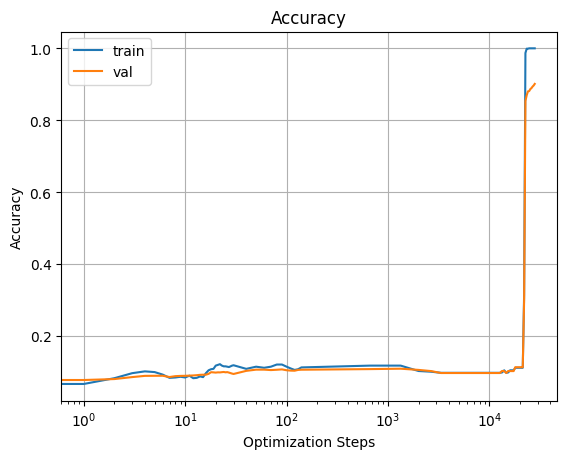

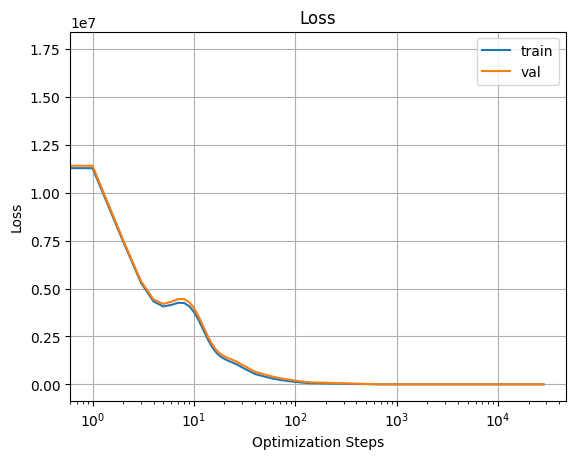

In [19]:
# Load the saved results for plotting/printing

results_dir = "/kaggle/working/results/mnist_online"
filename = f"mnist_{args.label}.pt"
results_filename = os.path.join(results_dir, filename)

filename_plot_acc = f"mnist_{args.label}_acc.png"
results_filename_plot_acc = os.path.join(results_dir, filename_plot_acc)

filename_plot_loss = f"mnist_{args.label}_loss.png"
results_filename_plot_loss = os.path.join(results_dir, filename_plot_loss)



results = torch.load(results_filename, weights_only=True)


# Extract data from results
its = results["its"]  # Optimization steps
train_acc = results["train_acc"]  # Training accuracy
val_acc = results["val_acc"]  # Validation accuracy
train_loss = results["train_loss"]  # Training loss
val_loss = results["val_loss"]  # Validation loss
steps_to_reach = results["steps_to_reach"]  # Steps to reach 90% validation accuracy

print(f"Steps needed to reach 0.9 validation accuracy: {steps_to_reach}")

# Plot Accuracy
plt.figure()
plt.plot(its, train_acc, label="train")
plt.plot(its, val_acc, label="val")
plt.legend()
plt.title(f"Accuracy")
plt.xlabel("Optimization Steps")
plt.ylabel("Accuracy")
plt.xscale("log", base=10)
plt.grid()
plt.savefig(results_filename_plot_acc, dpi=150)
# plt.close()

# Plot Loss
plt.figure()
plt.plot(its, train_loss, label="train")
plt.plot(its, val_loss, label="val")
plt.legend()
plt.title(f"Loss")
plt.xlabel("Optimization Steps")
plt.ylabel("Loss")
plt.xscale("log", base=10)
plt.grid()
plt.savefig(results_filename_plot_loss, dpi=150)
# plt.close()

print("Plots loaded successfully.")
